## Light curve from TESS for TIC43529091

TIC43529091 has been identified using GALAH and WiFeS spectra to likely be a double-generate single-line spectroscopic binary. The visible star is an extremely low mass white dwarf ($\mathrm{mass} < 0.3 M_\odot$).

I am curious to see if there is anything interesting in the TESS light curve.

In [37]:
import lightkurve as lk
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

Download the cutout from the TESS images

In [2]:
tpf = lk.search_tesscut('TIC43529091').download(cutout_size=(100, 100))

Create a mask for the star and check it looks okay

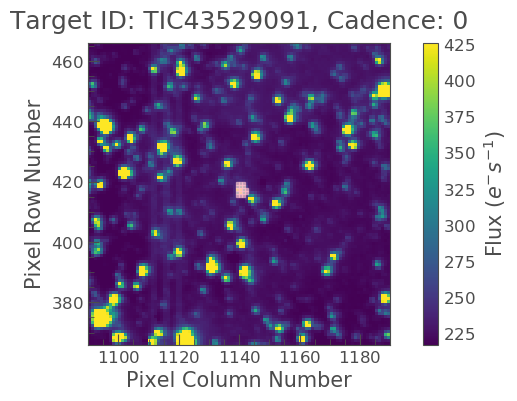

In [3]:
aper = tpf.create_threshold_mask()
tpf.plot(aperture_mask=aper);

Create a light curve

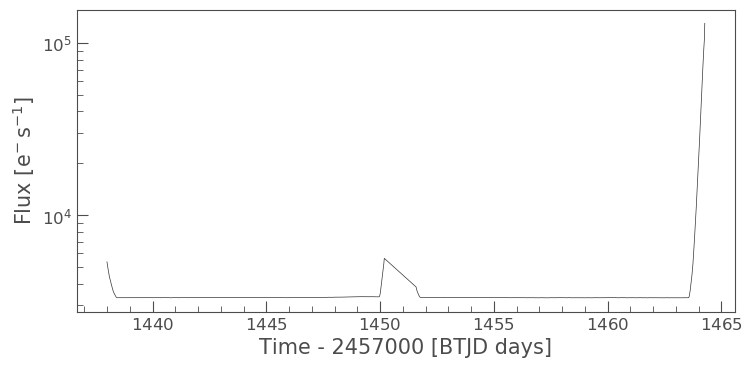

In [7]:
raw_lc = tpf.to_lightcurve(aperture_mask=aper)
ax = raw_lc.plot()
ax.set_yscale('log')

There are some pretty outrageous increases in flux at the start and end. Let's have a look at these interactively.

In [9]:
tpf.interact(aperture_mask=aper)

So it looks like there is a huge scattered light (?) problem during some of the observations. So I'm going to mask out those observations.

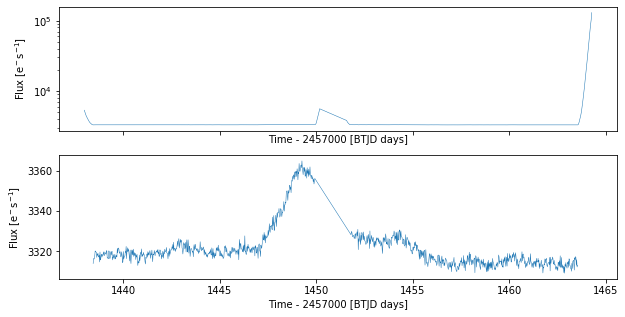

In [32]:
mask = ((tpf.time>1438.45) & (tpf.time<1449.95)) |  ((tpf.time>1451.8) & (tpf.time<1463.55))

tpf_masked = tpf[mask]
aper_masked = tpf_masked.create_threshold_mask()
raw_lc_masked = tpf_masked.to_lightcurve(aperture_mask=aper_masked)


fig, axes = plt.subplots(nrows=2,
                         ncols=1,
                         figsize=(10, 5), sharex=True)
raw_lc.plot(ax=axes[0])
raw_lc_masked.plot(ax=axes[1])
axes[0].set_yscale('log')

I have checked using the interactive window, and this same structure is evident in other stars in the field.

I am following along with the tutorial at https://docs.lightkurve.org/tutorials/04-how-to-remove-tess-scattered-light-using-regressioncorrector.html to remove the rest of the scattered light.

We can select these pixels very simply by specifying flux outside the aperture using Python’s bitwise invert operator ~ to take the inverse of the aperture mask.

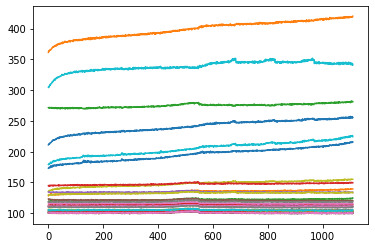

In [38]:
regressors = tpf_masked.flux[:, ~aper]
plt.plot(regressors[:, :30]);

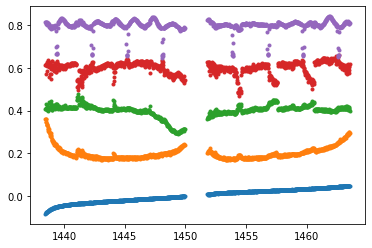

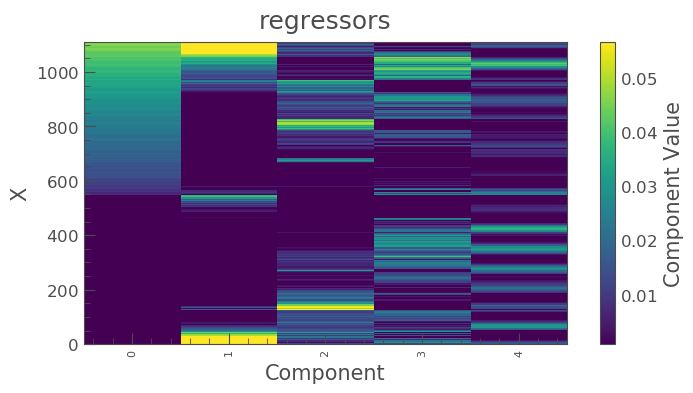

In [42]:
dm = lk.DesignMatrix(regressors, name='regressors').pca(5)
plt.plot(tpf_masked.time, dm.values + np.arange(5)*0.2, '.');
dm.plot();
dm = dm.append_constant()

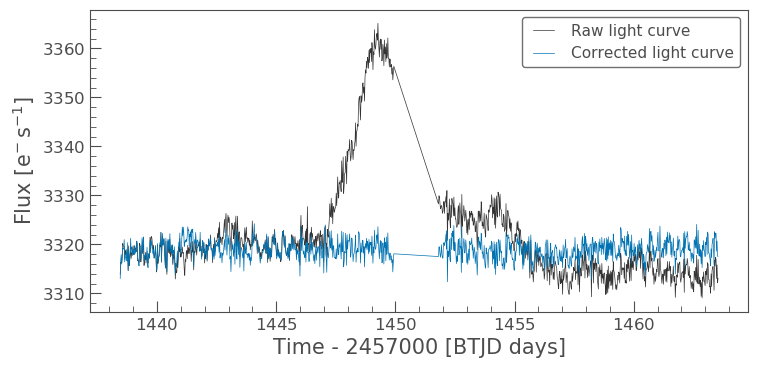

In [45]:
corrector = lk.RegressionCorrector(raw_lc_masked)
corrected_lc = corrector.correct(dm)

ax = raw_lc_masked.plot(label='Raw light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve');

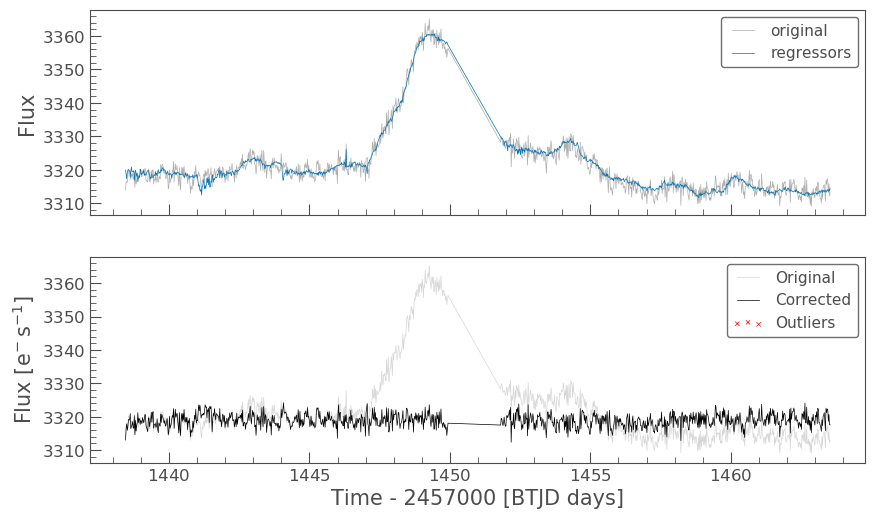

In [46]:
corrector.diagnose();

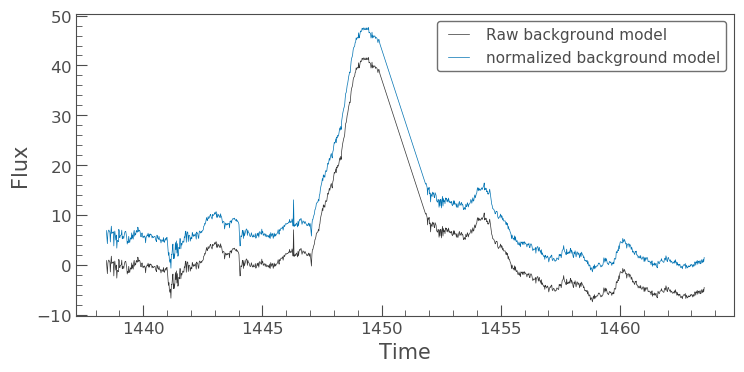

In [51]:
model = corrector.model_lc
ax = model.plot(label='Raw background model');
# Normalize to the 5th percentile of model flux
model -= np.percentile(model.flux, 5)
model.plot(ax=ax, label='normalized background model');

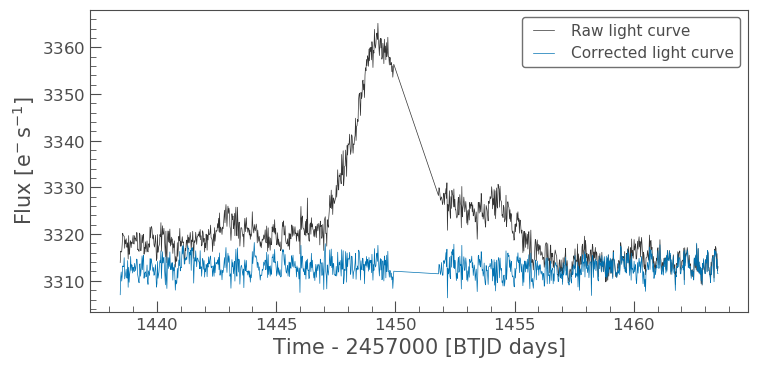

In [55]:
corrected_lc = raw_lc_masked - model
ax = raw_lc_masked.plot(label='Raw light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve');

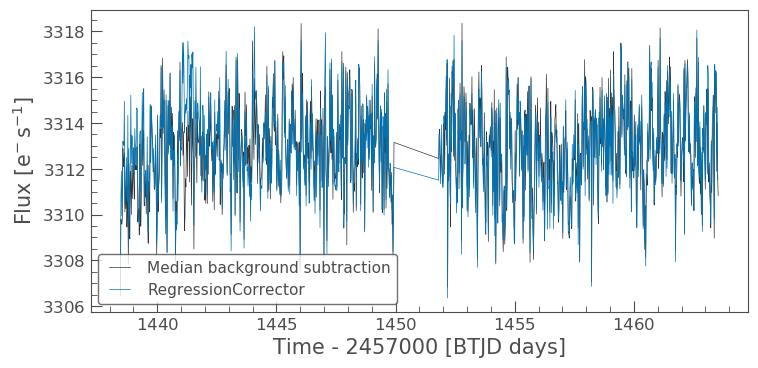

In [56]:
bkg = np.median(regressors, axis=1)
bkg -= np.percentile(bkg, 5)

npix = aper_masked.sum()
median_subtracted_lc = raw_lc_masked - npix * bkg

ax = median_subtracted_lc.plot(label='Median background subtraction')
corrected_lc.plot(ax=ax, label='RegressionCorrector');

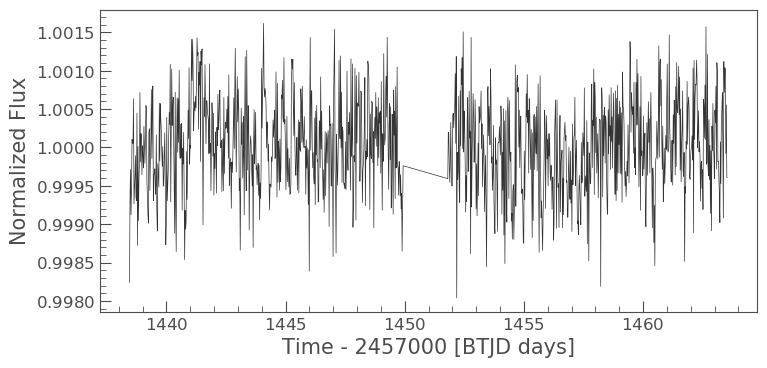

In [78]:
corrected_lc_normed = corrected_lc.normalize().remove_nans().remove_outliers()
corrected_lc_normed.plot();

Creating the periodogram to look for anything interesting

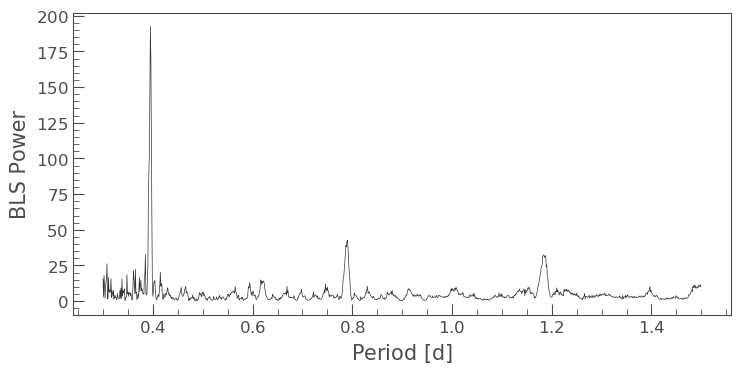

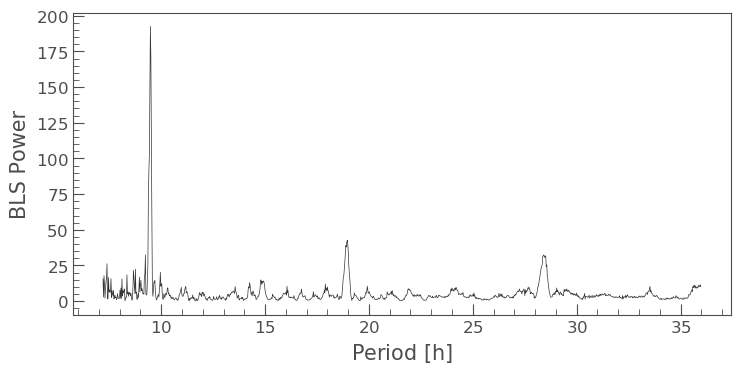

In [99]:
pg = corrected_lc_normed.to_periodogram(method="bls", period=np.arange(0.3, 1.5, 0.001))
ax = pg.plot();
ax = pg.plot(view='Period', unit=u.hour)

In [101]:
print(f"The peak in the periodogram is at {pg.period_at_max_power.to(u.hour):0.2f}")

The peak in the periodogram is at 9.48 h


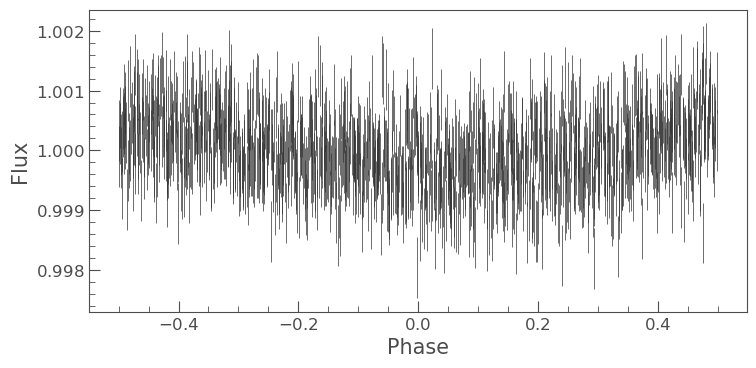

In [106]:
folded_lc = corrected_lc_normed.fold(period=pg.period_at_max_power, t0=pg.transit_time_at_max_power).errorbar();

Maybe?